In [1]:
# this version will create out-of-sample testing

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd

#load the consolidated dataset
df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')

# remove extra rows and columns
df = df.iloc[200:5383, 0:62]

# reformat Local time variable as a datetime
from datetime import datetime

df['Date'] = df['Date'].str[6:10] +'-'+ df['Date'].str[3:5] +'-'+ df['Date'].str[0:2]
df['Date'] = pd.to_datetime(df['Date'])

df.shape[0]

C:\Users\alexm\AppData\Local\Temp\ipykernel_17800\3067084044.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\alexm\FX_project\2000_2024\data2.csv')


5183

In [65]:
# normalise data

df_norm = df.iloc[:, 5:]
df_dates = df.iloc[:, :5]

for col in df_norm.columns:
    df_norm[col] = (df_norm[col] - df_norm[col].mean())/ df_norm[col].std()

x = df_norm.to_numpy()
y = df_dates.to_numpy()
cols = df.columns
z = np.append(y,x, axis=1)

df_norm2 = pd.DataFrame(z, columns=cols)

# add an integer series to replace date for use in the ANN
df_norm2['DateID'] = range(df_norm2.shape[0])
first_column = df_norm2.pop('DateID') 
df_norm2.insert(0, 'DateID', first_column)

df_norm2.iloc[:,2:] = df_norm2.iloc[:,2:].astype(float)

df_norm2.tail()

,DateID,Date,Day,Month,Year,Close_Mid,Volume_Bid,Volume_Ask,Volume_Tot,Close_Sprd,...,UK-NomGDP,UK-CPI,UK-Unemp,UK-CorpProf,UK-HshldInc,UK-ResPropInc,UK-SecLend,UK-ConsCred,UK-RetailVol,UK-MktVol
5178,5178,2023-12-24,24.0,12.0,2023.0,1.269530,-0.615293,-0.596937,-0.607105,6.347332,...,2.253473,2.631863,-0.578174,2.218245,2.275506,2.39071,-0.316785,1.001333,-1.621908,0.446187
5179,5179,2023-12-25,25.0,12.0,2023.0,1.272510,-0.313791,-0.133648,-0.223467,-0.623537,...,2.253473,2.631863,-0.578174,2.218245,2.275506,2.39071,-0.316785,1.001333,-1.621908,0.446187
5180,5180,2023-12-26,26.0,12.0,2023.0,1.279820,-0.397826,-0.340229,-0.369464,-0.623537,...,2.253473,2.631863,-0.578174,2.218245,2.275506,2.39071,-0.316785,1.001333,-1.621908,0.446187
5181,5181,2023-12-27,27.0,12.0,2023.0,1.273285,-0.295915,-0.295359,-0.296149,-0.409519,...,2.253473,2.631863,-0.578174,2.218245,2.275506,2.39071,-0.316785,1.001333,-1.621908,0.446187
5182,5182,2023-12-28,28.0,12.0,2023.0,1.273155,-0.231447,-0.188533,-0.210203,0.140813,...,2.253473,2.631863,-0.578174,2.218245,2.275506,2.39071,-0.316785,1.001333,-1.621908,0.446187


In [4]:
# first a function to generate an n-step timeseries from one feature

# i = length of time series, feat = name of column
def datats(i,feat):
    series = []
    data = df_norm2[feat]
    
    # create the dataset
    for j in range(len(data) - i +1):
        series.append(data[j:j+i])
    series = np.array(series)
    series = np.asfarray(series)
    
    # create the column names
    lst = []
    cols = np.array(lst)
    for k in range(i):
        cols = np.append(cols,feat+'-'+str(k))
    # generate the dataframe
    df_ts = pd.DataFrame(series, columns=cols)

    # add the date ID of the start of the timeseries for reference
    df_ts['DateID'] = df_norm2['DateID'][0:len(data) - i +1]
    # shift column 'C' to first position 
    first_column = df_ts.pop('DateID')
    # insert column using insert(position,column_name,first_column) function 
    df_ts.insert(0, 'DateID', first_column)
    
    return df_ts


In [5]:
# function test
x = datats(3,'Close_Mid')
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5181 entries, 0 to 5180
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateID       5181 non-null   int64  
 1   Close_Mid-0  5181 non-null   float64
 2   Close_Mid-1  5181 non-null   float64
 3   Close_Mid-2  5181 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 162.0 KB


In [6]:
# build a time series of m steps for the forecasted price, m+n steps for input features and n for output
# to do this we create all timeseries for each input/output as per the above and then inner join on DateID to get dates consistent

feats = ['Volume_Tot','Close_Sprd','US-BaseRate', 'UK-BaseRate','UK-5Y-Inf','US-2Y-Int',
                     'US-10Y-Int','UK-2Y-Int','UK-10Y-Int','US-RealGDP','US-Unemp', 'US-CPI','US-HousePrice',
                     'US-CommmRealEst','US-MktVol','UK-RealGDP','UK-CPI','UK-Unemp','UK-CorpProf',
                     'UK-HshldInc','UK-ResPropInc','UK-SecLend','UK-ConsCred','UK-RetailVol','UK-MktVol']
m = 750
n = 250

ts_in = datats(m,'Close_Mid')

for k in range(len(feats)):
    temp = datats(m+n,feats[k])
    ts_in = ts_in.merge(temp, on='DateID')

ts_out = datats(n,'Close_Mid')
ts_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4184 entries, 0 to 4183
Columns: 25751 entries, DateID to UK-MktVol-999
dtypes: float64(25750), int64(1)
memory usage: 822.0 MB


In [7]:
# trim the datasets to match assuming n<m (i.e. output timeseries is smaller than input)
# note we need to reindex

# remove the first m time steps from the output
ts_out = ts_out.iloc[m:ts_out.shape[0],].reset_index()

# remove the last n timesteps from the input
ts_in = ts_in.iloc[0:ts_in.shape[0],].reset_index()

In [10]:
df_norm2.iloc[:5,:]

,DateID,Date,Day,Month,Year,Close_Mid,Volume_Bid,Volume_Ask,Volume_Tot,Close_Sprd,...,UK-NomGDP,UK-CPI,UK-Unemp,UK-CorpProf,UK-HshldInc,UK-ResPropInc,UK-SecLend,UK-ConsCred,UK-RetailVol,UK-MktVol
0,0,2004-02-08,8.0,2.0,2004.0,1.86077,-0.108425,-0.163825,-0.136559,-0.990425,...,-1.594999,-1.521179,-0.510423,-1.612364,-1.684136,-1.475755,2.743055,1.654251,1.138495,-0.375961
1,1,2004-02-09,9.0,2.0,2004.0,1.86755,-0.128922,-0.180773,-0.155302,-0.990425,...,-1.594999,-1.521179,-0.510423,-1.612364,-1.684136,-1.475755,2.743055,1.654251,1.138495,-0.375961
2,2,2004-02-10,10.0,2.0,2004.0,1.89076,-0.131869,-0.179118,-0.155932,-0.684685,...,-1.594999,-1.521179,-0.510423,-1.612364,-1.684136,-1.475755,2.743055,1.654251,1.138495,-0.375961
3,3,2004-02-11,11.0,2.0,2004.0,1.89239,-0.110957,-0.169778,-0.140821,-0.990425,...,-1.594999,-1.521179,-0.510423,-1.612364,-1.684136,-1.475755,2.743055,1.654251,1.138495,-0.375961
4,4,2004-02-12,12.0,2.0,2004.0,1.88505,-0.128374,-0.181841,-0.155568,-0.990425,...,-1.594999,-1.521179,-0.510423,-1.612364,-1.684136,-1.475755,2.743055,1.654251,1.138495,-0.375961


In [9]:
# align the dates of the 
print('input')
print(ts_in.shape)
print(ts_in['DateID'][0])
print(ts_in['DateID'][ts_in.shape[0]-1])

print('output')
print(ts_out.shape)
print(ts_out['DateID'][0])
print(ts_out['DateID'][ts_out.shape[0]-1])

ts_in.iloc[0,1:]

input
(4184, 25752)
0
4183
output
(4184, 252)
750
4933


DateID           0.000000
Close_Mid-0      1.860770
Close_Mid-1      1.867550
Close_Mid-2      1.890760
Close_Mid-3      1.892390
                   ...   
UK-MktVol-995    0.330573
UK-MktVol-996    0.330573
UK-MktVol-997    0.330573
UK-MktVol-998    0.330573
UK-MktVol-999    0.330573
Name: 0, Length: 25751, dtype: float64

In [83]:
# generate data for test/train
# exclude the index for inputs
X = ts_in.iloc[:,1:].values

# drop the Startdate and index for output
y = ts_out.iloc[:,2:].values

# Create a train/test set and forecast set
# 2017 = 2361
# 2018 = 2622
# 2019 = 2882
# 2020 = 3142
# 2021 = 3403
# 2022 = 3663
# 2023 = 3923

split_index = 2882

X_fcst = X[split_index:,:]
y_fcst = y[split_index:]

# the rest of the data is for training and testing
X_trn = X[:split_index,:]
y_trn = y[:split_index]


In [84]:
# check the dataframes have what we need
print('input')
print(ts_in.iloc[:,1:].shape)
print(ts_in.iloc[:,1:]['DateID'][0])
print(ts_in.iloc[:,1:]['DateID'][ts_in.shape[0]-1])

print('output')
print(ts_out.iloc[:,2:].shape)
print(ts_out.iloc[:,1:]['DateID'][0]) # include col2 because this contains the ID of the start/end date
print(ts_out.iloc[:,1:]['DateID'][ts_out.shape[0]-1])

ts_in.iloc[:,2:].tail()

input
(4184, 25751)
0
4183
output
(4184, 250)
750
4933


,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,Close_Mid-8,Close_Mid-9,...,UK-MktVol-990,UK-MktVol-991,UK-MktVol-992,UK-MktVol-993,UK-MktVol-994,UK-MktVol-995,UK-MktVol-996,UK-MktVol-997,UK-MktVol-998,UK-MktVol-999
4179,1.293130,1.300445,1.289830,1.288670,1.281700,1.275345,1.281430,1.287110,1.295420,1.304915,...,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187
4180,1.300445,1.289830,1.288670,1.281700,1.275345,1.281430,1.287110,1.295420,1.304915,1.312595,...,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187
4181,1.289830,1.288670,1.281700,1.275345,1.281430,1.287110,1.295420,1.304915,1.312595,1.290725,...,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187
4182,1.288670,1.281700,1.275345,1.281430,1.287110,1.295420,1.304915,1.312595,1.290725,1.281890,...,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187
4183,1.281700,1.275345,1.281430,1.287110,1.295420,1.304915,1.312595,1.290725,1.281890,1.256965,...,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187,0.446187


In [85]:
print(X_trn.shape)
print(y_trn.shape)
print(X_fcst.shape)
print(y_fcst.shape)

(2882, 25751)
(2882, 250)
(1302, 25751)
(1302, 250)


In [86]:
# this is the actual data to compare to the forecast (the last element of the dataset)
y_fcst[-1:,:]

array([[1.21942 , 1.22886 , 1.234605, 1.23904 , 1.239615, 1.23795 ,
        1.23337 , 1.24033 , 1.240785, 1.23972 , 1.23512 , 1.23177 ,
        1.237445, 1.22251 , 1.20585 , 1.201825, 1.204755, 1.20718 ,
        1.212205, 1.20589 , 1.21393 , 1.217275, 1.20339 , 1.199635,
        1.20368 , 1.204215, 1.21116 , 1.204615, 1.20138 , 1.19438 ,
        1.206475, 1.202105, 1.202835, 1.194605, 1.2045  , 1.20249 ,
        1.1832  , 1.18445 , 1.19264 , 1.20307 , 1.218305, 1.21584 ,
        1.20576 , 1.210965, 1.217715, 1.227905, 1.22174 , 1.2267  ,
        1.228605, 1.223265, 1.22862 , 1.234255, 1.23139 , 1.238645,
        1.233485, 1.24146 , 1.250115, 1.246245, 1.24399 , 1.241875,
        1.238205, 1.24244 , 1.24851 , 1.25232 , 1.241455, 1.23765 ,
        1.242475, 1.243955, 1.244275, 1.244215, 1.24859 , 1.240855,
        1.246865, 1.2497  , 1.256655, 1.24963 , 1.24669 , 1.25641 ,
        1.257415, 1.263115, 1.261875, 1.26203 , 1.262545, 1.25099 ,
        1.244805, 1.252885, 1.248805, 1.24879 , 

In [87]:
# and this is the model input for the out-of-sample forecast
X_fcst[-1:,:]

array([[4.18300000e+03, 1.28170000e+00, 1.27534500e+00, ...,
        4.46187265e-01, 4.46187265e-01, 4.46187265e-01]])

In [88]:
# Generate an adaptable fully connected neural net with the correct size of input/ouput layers from the above dataset
nodes = 500
slope = 0.3

model = nn.Sequential(nn.Linear(ts_in.iloc[:,1:].shape[1], nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes,nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes,nodes),nn.LeakyReLU(negative_slope=slope),
                      nn.Linear(nodes, ts_out.iloc[:,2:].shape[1]),nn.LeakyReLU(negative_slope=slope))

# Tanh, Sigmoid don't work very well since the range of the functions is limited to [-1,1] or [0,1]

# set parameters of the learning
criterion = nn.MSELoss()
epochs = 1000
rand_st = 42 # random state

# optimiser and learning rate
opt = torch.optim.Adam(model.parameters(), lr = 0.001)

# container for tests
results = np.empty((0, 5))


# train the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_trn, y_trn, test_size = 0.2, random_state=rand_st)

# convert to tensor for use in pyTorch
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# seed a random number to replicate data
torch.manual_seed(rand_st)

# train the model and capture the time taken

import time
t_start = time.time()

for i in range(epochs):
    # create predictions
    y_pred = model(X_train)

    # calculate loss and add to the list
    loss = criterion(y_pred, y_train)

    # performs back propogation
    opt.zero_grad()
    loss.backward()
    opt.step()

t_stop = time.time()
process_time = round((t_stop - t_start), 2)
print(process_time)

# calculate a prediction
pred = model(torch.FloatTensor(X))


764.88


In [89]:
pred.shape

torch.Size([4184, 250])

In [90]:
pred

tensor([[ 1.9216,  1.9197,  1.9565,  ...,  2.0085,  2.0114,  2.0049],
        [ 1.9211,  1.9252,  1.9602,  ...,  2.0105,  2.0127,  2.0044],
        [ 1.9247,  1.9290,  1.9627,  ...,  2.0139,  2.0164,  2.0046],
        ...,
        [ 0.6109, -0.2328, -0.2478,  ..., -0.4145,  1.2778, -0.4818],
        [ 0.5898, -0.2296, -0.2565,  ..., -0.4233,  1.2885, -0.4852],
        [ 0.5795, -0.2250, -0.2575,  ..., -0.4210,  1.2924, -0.4852]],
       grad_fn=<LeakyReluBackward0>)

In [91]:
# calculate the MSE for this model
mse = nn.MSELoss()

# create a target tensor from the ts_out dataframe
target = torch.FloatTensor(ts_out.iloc[:,2:].values)
output = mse(pred, target)
print("MSE loss:", output.item())

MSE loss: 0.24705052375793457


In [92]:
# visualise results
# convert tensors to dataframes

cols = ts_out.iloc[:,2:].columns
df_pred = pd.DataFrame(pred.detach().numpy(),columns=cols)
df_target = pd.DataFrame(target.detach().numpy(),columns=cols)

# attach correct start dates
df_pred['DateID'] = ts_out.iloc[:,1:2]
fc1 = df_pred.pop('DateID') # insert column using insert(position,column_name,first_column) function 
df_pred.insert(0, 'DateID', fc1)
df_pred['DateID'] = ts_out.iloc[:,1:2]

df_target['DateID'] = ts_out.iloc[:,1:2]
fc2 = df_target.pop('DateID') # insert column using insert(position,column_name,first_column) function 
df_target.insert(0, 'DateID', fc2)
df_target['DateID'] = ts_out.iloc[:,1:2]

df_pred.tail()

,DateID,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,Close_Mid-8,...,Close_Mid-240,Close_Mid-241,Close_Mid-242,Close_Mid-243,Close_Mid-244,Close_Mid-245,Close_Mid-246,Close_Mid-247,Close_Mid-248,Close_Mid-249
4179,4929,0.624449,-0.235888,-0.248886,1.793208,-0.587657,-0.842985,-0.231034,1.409937,-0.274941,...,0.910628,-0.309872,-0.474548,0.534230,-1.556754,0.056280,1.496934,-0.414112,1.272626,-0.478674
4180,4930,0.623879,-0.231474,-0.247124,1.782740,-0.590112,-0.848077,-0.230496,1.391947,-0.270707,...,0.926845,-0.304980,-0.478169,0.524778,-1.560862,0.057599,1.480987,-0.417240,1.280128,-0.481455
4181,4931,0.610884,-0.232774,-0.247820,1.768078,-0.583937,-0.847678,-0.237366,1.403341,-0.266667,...,0.891145,-0.310872,-0.477373,0.529131,-1.560490,0.037924,1.500540,-0.414540,1.277810,-0.481803
4182,4932,0.589806,-0.229593,-0.256454,1.779712,-0.589668,-0.852330,-0.236982,1.394804,-0.270402,...,0.906144,-0.310093,-0.481741,0.536227,-1.568698,0.051079,1.492193,-0.423308,1.288528,-0.485224
4183,4933,0.579508,-0.224984,-0.257459,1.774934,-0.590954,-0.857662,-0.242060,1.394001,-0.268973,...,0.929395,-0.312857,-0.482295,0.529227,-1.562239,0.042202,1.510499,-0.420951,1.292449,-0.485210


In [93]:
# generate the results in original format by taking a row of data and attaching correct dates

# attach start date to dataframe

df_pred2 = df_pred.merge(df_norm2.iloc[:,0:2], on='DateID')
df_pred2.head()
fc3 = df_pred2.pop('Date')
df_pred2.insert(1, 'Date', fc3)

df_target2 = df_target.merge(df_norm2.iloc[:,0:2], on='DateID')
df_target2.head()
fc3 = df_target2.pop('Date')
df_target2.insert(1, 'Date', fc3)

df_pred2.tail()

,DateID,Date,Close_Mid-0,Close_Mid-1,Close_Mid-2,Close_Mid-3,Close_Mid-4,Close_Mid-5,Close_Mid-6,Close_Mid-7,...,Close_Mid-240,Close_Mid-241,Close_Mid-242,Close_Mid-243,Close_Mid-244,Close_Mid-245,Close_Mid-246,Close_Mid-247,Close_Mid-248,Close_Mid-249
4179,4929,2023-01-09,0.624449,-0.235888,-0.248886,1.793208,-0.587657,-0.842985,-0.231034,1.409937,...,0.910628,-0.309872,-0.474548,0.534230,-1.556754,0.056280,1.496934,-0.414112,1.272626,-0.478674
4180,4930,2023-01-10,0.623879,-0.231474,-0.247124,1.782740,-0.590112,-0.848077,-0.230496,1.391947,...,0.926845,-0.304980,-0.478169,0.524778,-1.560862,0.057599,1.480987,-0.417240,1.280128,-0.481455
4181,4931,2023-01-11,0.610884,-0.232774,-0.247820,1.768078,-0.583937,-0.847678,-0.237366,1.403341,...,0.891145,-0.310872,-0.477373,0.529131,-1.560490,0.037924,1.500540,-0.414540,1.277810,-0.481803
4182,4932,2023-01-12,0.589806,-0.229593,-0.256454,1.779712,-0.589668,-0.852330,-0.236982,1.394804,...,0.906144,-0.310093,-0.481741,0.536227,-1.568698,0.051079,1.492193,-0.423308,1.288528,-0.485224
4183,4933,2023-01-15,0.579508,-0.224984,-0.257459,1.774934,-0.590954,-0.857662,-0.242060,1.394001,...,0.929395,-0.312857,-0.482295,0.529227,-1.562239,0.042202,1.510499,-0.420951,1.292449,-0.485210


Text(0.5, 0, 'Date')

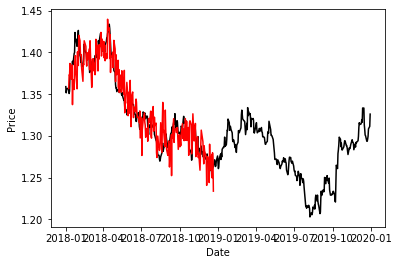

In [95]:
# visualise results by adding in a line of forecast results to the real data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# pick a date for the time series and capture that 100 elements with the DateID
fcst_date = '2018-01-07'
d = pd.to_datetime(fcst_date)
fcst = df_pred2.loc[df_pred2['Date']==d]

fcst_container = pd.DataFrame(fcst.iloc[:,0:3],columns=['DateID','Date','Close_Mid'])

# reattach the date for all elements of the timeseries
for e in range(1,len(fcst.iloc[:,2:].to_numpy()[0]),1):
    a = fcst.iloc[0,0] + e
    b = df_norm2.loc[df_norm2['DateID']==a]['Date'].values[0]
    c = fcst.iloc[0,e+2]
    lst = [a,b,c]
    fcst_container.loc[len(fcst_container)] = lst

results_filtered = df_norm2[(df_norm2['Year'] == 2018) + (df_norm2['Year'] == 2019)]

plt.plot(results_filtered['Date'], results_filtered['Close_Mid'], color='black')
plt.plot(fcst_container['Date'], fcst_container['Close_Mid'], color='red')
plt.ylabel('Price')
plt.xlabel('Date')